### Imports

In [36]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

### Funções e Classes

In [37]:
def fences(func):
    def use_fences(dataframe, column):
        Q1 = dataframe[column].describe()["25%"]
        Q3 = dataframe[column].describe()["75%"]
        IQR = Q3 - Q1

        upper_fence = Q3 + 1.5 * IQR
        lower_fence = Q1 - 1.5 * IQR
        return func(dataframe, column, upper_fence, lower_fence) 
    return use_fences


@fences
def select_outliers(dataframe, column, upper_fence, lower_fence):
    return dataframe.loc[(dataframe[column] < lower_fence) | (dataframe[column] > upper_fence)] 


@fences
def filter_outliers(dataframe, column, upper_fence, lower_fence):
    return dataframe.loc[(dataframe[column] > lower_fence) & (dataframe[column] < upper_fence)] 




## Features e Target

Motivos para remoção das features contidas em `features_not_used`:

- `id` & `project_id`: Identificadores que seus valores não representam uma caracteristica desejada no modelo;
- `name`: Variável categórica que apenas contém o nome do projeto e que não agrega em características práticas para um modelo ser treinado;
- `about_html` e `budget`: Features que contém HTML e texto que seria necessário uso de técnicas como pln para criar características para um modelo;
- `tag_list`: Lista com textos que assim como os conteúdos em HTM que teriam que sofrer outros processamentos para criação de classes utilizaveis nos modelos;
- `content_rating`: Faz a mesma coisa que `is_adult_content`;
- `city` e `state_acronym`: Informações sonbre regiões que não foram selecionadas e desejadas para a classificação do modelo em nessas etapas iniciais;
- `progress`: Possível __dataleak__ visto que é o resultado percentual de `goal` alcançar a feature;
- `posts_count`: Possui os mesmos valores que a feature `total_posts`.

In [38]:
df = pd.read_pickle('../databases/project_details.pkl')

In [39]:
features_not_used = ['id',
                 'project_id',
                 'name',
                 'about_html',
                 'budget',
                 'state_order',
                 'tag_list',
                 'contributed_by_friends',
                 'content_rating',
                 'city',
                 'state_acronym',
                 'progress', #dataleak
                 'posts_count',
                 ]

target = 'pledged'

features = list(filter(lambda x: x not in features_not_used and x != target, df.columns))

print(features)

['goal', 'category_id', 'total_contributions', 'total_contributors', 'state', 'mode', 'expires_at', 'online_days', 'total_posts', 'is_adult_content', 'recommended', 'video_embed_url', 'video_url', 'thumb_image', 'online_date_convert']


## Drops

In [40]:

def select_drops():
    global df
    quant_linhas_originais = df.shape[0]

    # Drops
    max_goal = df.loc[(df['state'] == 'successful') & (df['progress'] >= 100), 'goal'].max()

    df = df.loc[df['goal'] <= max_goal]

    #df = filter_outliers(df, 'pledged')

    #df = df.loc[df['online_days'] <= 365]

    quant_linhas_atuais = df.shape[0]

    return f"Quantidade de registros originais {quant_linhas_originais} \n" \
           f"Quantidade de linhas atuais {quant_linhas_atuais} \n" \
           f"Linhas removidas:{quant_linhas_originais - quant_linhas_atuais} \n" \
           f"Percentual:{round((1 - (quant_linhas_atuais / quant_linhas_originais)),2) * 100}%"




In [7]:
# Teste sem drops

# drops = select_drops()
# print(drops)

## Dados de Treino, Validação e Teste

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer


# Eliminar as linhas com 'state' igual a 'waiting_funds'
df = df.loc[df['state'] != 'waiting_funds']

X = df[features]
y = df[target]



# Aplicar a transformação logarítmica em y
transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)
y = transformer.transform(y)


# Primeiro, dividir em treino + validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Em seguida, dividir o conjunto de treino + validação em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Proporções finais:
# Treino - 60%
# Validação - 20%
# Teste - 20%

### Histograma Target transformação logarítmica

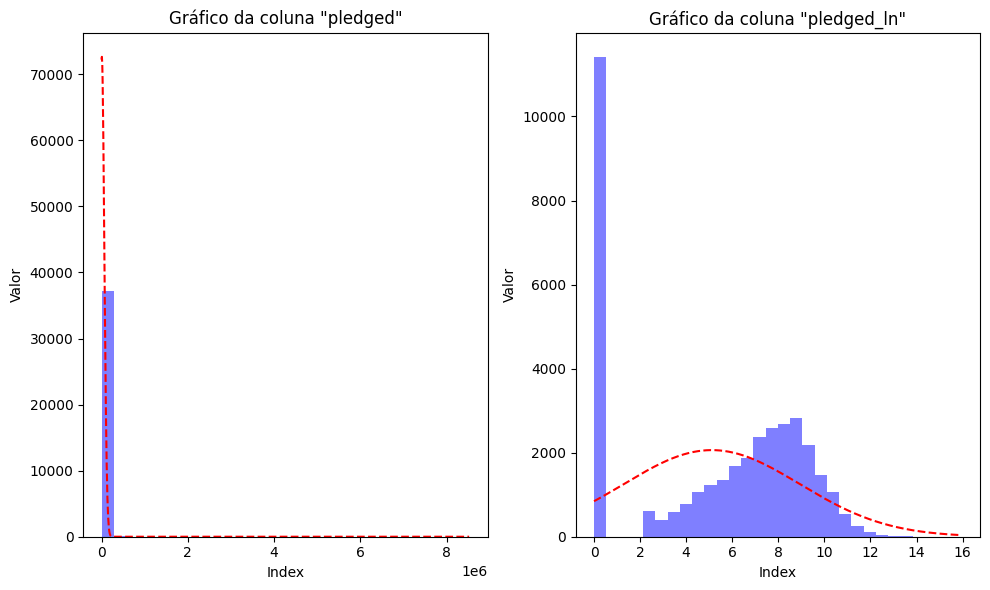

In [10]:

import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

df_copy = df.copy()

df_copy['pledged_ln'] = transformer.transform(df_copy['pledged'])


plt.figure(figsize=(10, 6))

columns_compare = ['pledged','pledged_ln']


for i in range(2):
    plt.subplot(1, 2, i + 1)  
    plt.hist(df_copy[columns_compare[i]],bins=30, facecolor='blue', alpha=0.5)
    if i == 0:
        plt.title('Gráfico da coluna "pledged"')
    else:
        plt.title('Gráfico da coluna "pledged_ln"')
    plt.xlabel('Index')
    plt.ylabel('Valor')

    # Calcular os parâmetros da distribuição normal
    params = stats.norm.fit(df_copy[columns_compare[i]])

    # Plotar a curva normal
    x = np.linspace(min(df_copy[columns_compare[i]]), max(df_copy[columns_compare[i]]), 1000)
    bin_width = (max(df_copy[columns_compare[i]]) - min(df_copy[columns_compare[i]])) / 30
    plt.plot(x, stats.norm.pdf(x, *params) * len(df_copy[columns_compare[i]]) * bin_width, 'r--')

plt.tight_layout()  # Ajustar a posição dos títulos e rótulos
plt.show()  


Ao comparar os histogramas, percebemos como a função logarítmica fez uma normalização o qual trouxe a distribuição dos dados bem próximo da curva normal

### Classe para métricas

In [42]:
class Result_models():
    def __init__(self, model):
        self.model = model


    def fit(self):
        self.model.fit(X_train, y_train)


    def fold(self, cross_val):
        self.fold_result = cross_val_score(self.model, X_val, y_val, cv=cross_val)
        print(f"Score por fold:{self.fold_result}")
        print(f"Score médio: {round(self.fold_result.mean(),4)}")


    def r2_score_result(self):
        return r2_score(y_test,self.model.predict(X_test))
    

    def mean_squared_error_result(self):
        return mean_squared_error(y_test,self.model.predict(X_test))


    def mean_absolute_error_result(self):
        return mean_absolute_error(y_test,self.model.predict(X_test))

    def metrics(self):
        return {
            'MSE': self.mean_squared_error_result(),
            'MAE': self.mean_absolute_error_result(),
            'R^2': self.r2_score_result()
        }
    

    def metrics_real(self, transformer):
        y_pred = transformer.inverse_transform(self.model.predict(X_test))
        return {
            "MSE":mean_squared_error(transformer.inverse_transform(y_test), y_pred),
            "MAE":mean_absolute_error(transformer.inverse_transform(y_test), y_pred),
            "R^2":r2_score(transformer.inverse_transform(y_test), y_pred),
        }

## Pipeline

In [43]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class FillMissingDatesTransformer(BaseEstimator, TransformerMixin):
    """
    Uma classe de transformador para preencher datas faltantes em DataFrame pandas.

    Atributos:
    online_days_median (float): A média dos dias online.
    online_days_median_timedelta (pandas.Timedelta): A representação de timedelta da média dos dias online.
    """

    def __init__(self):
        self.online_days_median = None
        self.online_days_median_timedelta = None

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados.

        Calcula a média dos dias online e converte-a em objeto timedelta.

        Parâmetros:
        X (pandas.DataFrame): Os dados de entrada.
        y (opcional): Não é utilizado nesse transformador.

        Retorna:
        self: O transformador ajustado.
        """
        self.online_days_median = X['online_days'].median()
        self.online_days_median_timedelta = pd.to_timedelta(self.online_days_median, unit="D")
        return self

    def fill_dates(self, row):
        """
        Preenche as colunas 'expires_at' e 'online_days' de uma linha no DataFrame.

        Se 'expires_at' for faltante, é preenchido com o timedelta da média dos dias online mais 'online_date_convert'. Se 'online_days' for faltante, é preenchido com a média dos dias online.

        Parâmetros:
        row (pandas.Series): Uma linha no DataFrame.

        Retorna:
        row (pandas.Series): A linha modificada.
        """
        if pd.isna(row['expires_at']):
            row['expires_at'] = row['online_date_convert'] + self.online_days_median_timedelta
            if pd.isna(row['online_days']):
                row['online_days'] = self.online_days_median
        return row

    def fill_days_interval(self, row):
        """
        Preenche a coluna 'online_days' de uma linha no DataFrame.

        Se 'online_days' for faltante e 'expires_at' e 'online_date_convert' não forem faltantes, é preenchido com a diferença entre 'expires_at' e 'online_date_convert'.

        Parâmetros:

        row (pandas.Series): Uma linha no DataFrame.

        Retorna:

        row (pandas.Series): A linha modificada.
        """
        missing_data_in_columns_date = (pd.isna(row['expires_at']) | pd.isna(row['online_date_convert']))
        if pd.isna(row['online_days']) and not missing_data_in_columns_date:
            row['online_days'] = (row['expires_at'] - row['online_date_convert']).days
        return row

    def transform(self, X):
        """
        Transforma o DataFrame de entrada aplicando as funções fill_dates e fill_days_interval a cada linha.

        Parâmetros:

        X (pandas.DataFrame): O DataFrame de entrada.

        Retorna:

        X (pandas.DataFrame): O DataFrame transformado.
        """
        X = X.apply(self.fill_dates, axis=1)
        X = X.apply(self.fill_days_interval, axis=1)
        return X


In [13]:

class ConvertDatesToNumeric(BaseEstimator, TransformerMixin):
    """
    Transformador para converter datas em números.

    Atributos:
    None
    """

    def transform(self, X):
        """
        Converte as colunas de data do DataFrame em números.

        Utiliza as 'online_date_convert' e 'expires_at' em específico.

        Parâmetros:
        X (pandas.DataFrame): O DataFrame de entrada.

        Retorna:
        X (pandas.DataFrame): O DataFrame com as colunas de data convertidas em números.
        """
        X['online_date_convert'] = X['online_date_convert'].astype('int64') // 10**9  # Converter para Unix timestamp
        X['expires_at'] = X['expires_at'].astype('int64') // 10**9
        return X

    def fit(self, X, y=None):
        """
        Ajusta o transformador aos dados.

        Não há ajuste necessário nesse transformador, pois apenas converte datas em números.

        Parâmetros:
        X (pandas.DataFrame): Os dados de entrada.
        y (opcional): Não é utilizado nesse transformador.

        Retorna:
        self: O transformador ajustado.
        """
        return self


In [62]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler



pipeline_numerical = Pipeline([
    ('fill_missing_dates', FillMissingDatesTransformer()),
    ('convert_dates', ConvertDatesToNumeric()),
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

pipeline_categorical = Pipeline([
    ('OneHotEncoder', OneHotEncoder(sparse_output=False))
])

categorical_columns = ['category_id', 'mode', 'state']

#numerical_columns = list(filter(lambda x: x not in categorical_columns, X_train.columns))

numerical_columns = list(filter(lambda x: x not in categorical_columns + ['goal', 'posts_count'], 
                                X_train.columns))

ln_transformer = Pipeline([
    ('transform', transformer)
])

pre_process = ColumnTransformer([
    ('numerical', pipeline_numerical, numerical_columns), 
    ('categorical', pipeline_categorical, categorical_columns),
    ('progess_ln', ln_transformer, ['goal',
                                    'total_posts',
                                    'total_contributions', 
                                    'total_contributors']) 
])

#'online_date_convert','expires_at'


In [63]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

## Nota sobre metrics e metrics_real:

Como nesse estudo foi feito a transformação logaritmica em `y`, metrics representam o desempenho na escala logarítmica, já o método `metrics_real` de `Models_regression` está retornando os valores reais e comparando seus resultados

## Regressão Linear

In [64]:
from sklearn.linear_model import LinearRegression


model_regressor = make_pipeline(pre_process, LinearRegression())

model_regressor.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('fill_missing_dates',
                                                                   FillMissingDatesTransformer()),
                                                                  ('convert_dates',
                                                                   ConvertDatesToNumeric()),
                                                                  ('standard',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_contributions',
                                                   'total_contributors',
                                                   'expires_at', 'online_days',
                                                   'total_posts',
                                                   'is_adult_cont...
                                                   'online_date_convert']),
                                                 ('categorical',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category_id', 'mode',
                                                   'state']),
                                                 ('progess_ln',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['goal', 'total_posts',
                                                   'total_contributions',
                                                   'total_contributors'])])),
                ('linearregression', LinearRegression())])

In [65]:
model_regressor.score(X_val, y_val)

0.9390230427274161

In [66]:
result_regressor = Result_models(model_regressor)

result_regressor.fold(cross_val)

Score por fold:[0.93954891 0.93888692 0.93273323 0.94546733 0.93996202]
Score médio: 0.9393


In [67]:
result_regressor.metrics()

{'MSE': np.float64(0.8569274607331449),
 'MAE': np.float64(0.7262349646551853),
 'R^2': 0.9422733241384376}

In [68]:
result_regressor.metrics_real(transformer)

{'MSE': np.float64(1859319979.9410238),
 'MAE': np.float64(6951.067123984815),
 'R^2': -0.9922102043282937}

Resultados:

A regressão linear não obteve nenhuma melhora com a nova pipeline

## RandomForest

In [69]:
from sklearn.ensemble import RandomForestRegressor

model_rf = make_pipeline(pre_process, RandomForestRegressor(random_state=42))

model_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('fill_missing_dates',
                                                                   FillMissingDatesTransformer()),
                                                                  ('convert_dates',
                                                                   ConvertDatesToNumeric()),
                                                                  ('standard',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_contributions',
                                                   'total_contributors',
                                                   'expires_at', 'online_days',
                                                   'total_posts',
                                                   'is_adult_cont...
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category_id', 'mode',
                                                   'state']),
                                                 ('progess_ln',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['goal', 'total_posts',
                                                   'total_contributions',
                                                   'total_contributors'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [70]:
model_rf.score(X_val, y_val)

0.9818788185276065

In [71]:
result_rf = Result_models(model_rf)

result_rf.fold(cross_val)

Score por fold:[0.98002484 0.9771367  0.98161707 0.98171493 0.98061554]
Score médio: 0.9802


In [72]:
result_rf.metrics()

{'MSE': np.float64(0.24902633081679879),
 'MAE': np.float64(0.28829760312553576),
 'R^2': 0.983224411704864}

In [73]:
result_rf.metrics_real(transformer)



{'MSE': np.float64(110502829.97160223),
 'MAE': np.float64(1565.7464022254564),
 'R^2': 0.8815992578729976}

Resultados:

Os resultados do RandomForest tiveram uma leve diminuição com os novos processos da pipeline

## KNN

### Curva do cotovelo

Método para escolher o melhor valor de K

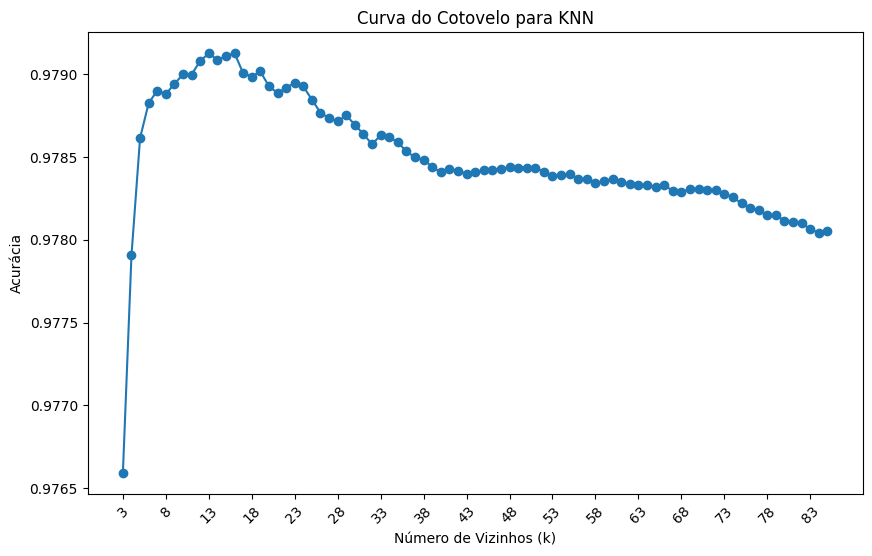

Melhor K:16 seu Score:0.9791267455564157


In [82]:
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

start_k = 3
range_k = int(X_test.shape[0] ** (1/2))
k_values = range(start_k, range_k)
accuracies = []


better_k_for_knn = {'k_number':0, 'score':0}
for k in k_values:
    cotovelo = make_pipeline(pre_process, KNeighborsRegressor(n_neighbors=k))
    cotovelo.fit(X_train, y_train)
    y_pred_cotovelo = cotovelo.predict(X_test)
    score = r2_score(y_test, y_pred_cotovelo)
    accuracies.append(score)
    if score > better_k_for_knn['score']:
        better_k_for_knn['k_number'] = k
        better_k_for_knn['score'] = score

# Plotar a curva do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.title('Curva do Cotovelo para KNN')
plt.xticks(k_values)
plt.xticks(ticks=range(start_k, range_k, 5), rotation=45)


plt.grid(False)
plt.show()

print(f'Melhor K:{better_k_for_knn["k_number"]} seu Score:{better_k_for_knn["score"]}')

In [87]:
from sklearn.neighbors import KNeighborsRegressor

model_KNN_regress = make_pipeline(pre_process, KNeighborsRegressor(n_neighbors=16))

model_KNN_regress.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('fill_missing_dates',
                                                                   FillMissingDatesTransformer()),
                                                                  ('convert_dates',
                                                                   ConvertDatesToNumeric()),
                                                                  ('standard',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_contributions',
                                                   'total_contributors',
                                                   'expires_at', 'online_days',
                                                   'total_posts',
                                                   'is_adult_cont...
                                                 ('categorical',
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category_id', 'mode',
                                                   'state']),
                                                 ('progess_ln',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['goal', 'total_posts',
                                                   'total_contributions',
                                                   'total_contributors'])])),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=16))])

In [88]:
result_KNN_regress = Result_models(model_KNN_regress)

result_KNN_regress.fold(cross_val)

Score por fold:[0.97430705 0.97001038 0.97854362 0.97808697 0.97463711]
Score médio: 0.9751


In [89]:
result_KNN_regress.metrics()

{'MSE': np.float64(0.3098544071803659),
 'MAE': np.float64(0.3217812357454678),
 'R^2': 0.9791267455564157}

In [90]:
result_KNN_regress.metrics_real(transformer)

{'MSE': np.float64(370944798.23663694),
 'MAE': np.float64(1951.4408270894228),
 'R^2': 0.6025428542358973}

Resultados:

Houve uma melhora significativa no KNN, apesar disso o MSE e MAE continuam altos, R^2 teve um aumento expressivo

## GradientBoosting

In [74]:
from sklearn.ensemble import GradientBoostingRegressor

# gradient boosted trees tend to do well on problems like this

model_reg = make_pipeline(pre_process, GradientBoostingRegressor(n_estimators=50, 
                                                                 random_state=42))


model_reg.fit(X_train, y_train)




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('fill_missing_dates',
                                                                   FillMissingDatesTransformer()),
                                                                  ('convert_dates',
                                                                   ConvertDatesToNumeric()),
                                                                  ('standard',
                                                                   StandardScaler()),
                                                                  ('minmax',
                                                                   MinMaxScaler())]),
                                                  ['total_contributions',
                                                   'total_contributors',
                                                   'expires_at', 'online_days',
                                                   'total_posts',
                                                   'is_adult_cont...
                                                  Pipeline(steps=[('OneHotEncoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['category_id', 'mode',
                                                   'state']),
                                                 ('progess_ln',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       inverse_func=<ufunc 'expm1'>))]),
                                                  ['goal', 'total_posts',
                                                   'total_contributions',
                                                   'total_contributors'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(n_estimators=50, random_state=42))])

In [76]:
model_reg.score(X_val, y_val)

0.9811156112934503

In [75]:
result_reg = Result_models(model_reg)

result_reg.fold(cross_val)

Score por fold:[0.98072644 0.97773632 0.9823302  0.98225904 0.98036557]
Score médio: 0.9807


In [77]:
result_reg.metrics()

{'MSE': np.float64(0.25837210178402564),
 'MAE': np.float64(0.32009365721434624),
 'R^2': 0.9825948364887308}

In [79]:
result_reg.metrics_real(transformer)

{'MSE': np.float64(448060618.42734647),
 'MAE': np.float64(2175.728868843638),
 'R^2': 0.519915374535523}

Resultados:

GradientBoosting teve resultados muito próximos aos anteriores se comparado com a nova pipeline

## Próximos passos

Como os novos processos da pipeline `StandardScaler` e `MinMaxScaler` não obtiveram sucesso, com excessão do KNN, que teve ganhos significativos. 

Agora é necessário encontrar o tratamento mais adequado para o modelo que trás mais ganhos e melhores métricas, como o tratamento de outliers, drops de certos registors e uma melhor normalizalçao além das transformações já abordadas.

A regressão linear será descontinuada nos próximos testes pois ela não está conseguindo alcançar bons resultados no conjunto de dados, mostrando como os dados estão relacionados não linearmente.
